In [4]:
from sklearn.model_selection import train_test_split
from cnn import ChessDataset, ChessEvaluationConvolutionalNetwork, ConvolutionInputModel
from torch.utils.data import DataLoader
import torch
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('../../data/chess_data.csv')
df = df[~df['Evaluation'].str.contains('#', na=False)]

df = df.reset_index(drop=True)


df['board_vec'] = df.apply(lambda row: ConvolutionInputModel.fen_to_feature_array(row['FEN'])[0].squeeze(0), axis=1)
df['meta_vec'] = df.apply(lambda row: ConvolutionInputModel.fen_to_feature_array(row['FEN'])[1].squeeze(0), axis=1)

X = df[['board_vec', 'meta_vec']]
df['Evaluation'] = pd.to_numeric(df['Evaluation'], errors='raise')
Y = (df['Evaluation'] - df['Evaluation'].min()) / (df['Evaluation'].max() - df['Evaluation'].min())
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Convert to a column tensor
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = ChessDataset(X_train, y_train_tensor)
test_dataset = ChessDataset(X_test, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)



In [5]:
import torch.nn as nn
import torch.optim as optim

batch_size = 32
epochs = 10
lr = 0.001


model = ChessEvaluationConvolutionalNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(epochs):
    running_loss = 0
    model.train()

    for x_board, x_meta, target in train_loader:
        optimizer.zero_grad()
        output = model(x_board, x_meta)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 0.0017
Epoch 2/10, Loss: 0.0011
Epoch 3/10, Loss: 0.0009
Epoch 4/10, Loss: 0.0007
Epoch 5/10, Loss: 0.0006
Epoch 6/10, Loss: 0.0006
Epoch 7/10, Loss: 0.0005
Epoch 8/10, Loss: 0.0004
Epoch 9/10, Loss: 0.0004
Epoch 10/10, Loss: 0.0004


In [ ]:
import numpy as np
model.eval()
test_loss = 0.0
output_vec = []
with torch.no_grad():
    for x_board, x_meta, target in test_loader:
        outputs = model(x_board, x_meta)
        loss = criterion(outputs, target)
        test_loss += loss.item()
        output_vec.extend(outputs.cpu().numpy().flatten())

avg_test_loss = test_loss / len(test_loader)
rmse_error = np.sqrt(avg_test_loss)
print(f"\nTest RMSE: {rmse_error:.4f}")
output_vec = np.array(output_vec)
correlation = np.corrcoef(output_vec, y_test)[0, 1]
print(f"\nCorrelation: {correlation}")


Test RMSE: 0.0268
[0.5418933, 0.5366315, 0.54341453, 0.5277411, 0.54440945, 0.5168587, 0.5339448, 0.5282688, 0.53807425, 0.5284588, 0.54605585, 0.52244496, 0.5421604, 0.55764186, 0.55258626, 0.5472204, 0.5409265, 0.54591924, 0.55364794, 0.55423075, 0.55527693, 0.5470701, 0.53944004, 0.5425917, 0.544543, 0.5296347, 0.5410213, 0.54309446, 0.54303604, 0.5464405, 0.54471433, 0.5363804, 0.54824924, 0.54737955, 0.5309017, 0.5417219, 0.5480673, 0.5455435, 0.54802585, 0.54083985, 0.53941, 0.54376686, 0.5458644, 0.5436697, 0.5681363, 0.5331344, 0.5530127, 0.5411495, 0.55552804, 0.54766417, 0.5376971, 0.5431201, 0.5451522, 0.5423456, 0.55200505, 0.5440175, 0.5420716, 0.53224784, 0.53852487, 0.5445284, 0.54163873, 0.54305756, 0.5232857, 0.5546085, 0.54484916, 0.5388414, 0.541705, 0.5365288, 0.5374353, 0.526735, 0.5403501, 0.5367161, 0.5434581, 0.53387785, 0.5427957, 0.54840976, 0.5438017, 0.54074776, 0.5422876, 0.54198575, 0.54188573, 0.54323983, 0.54094535, 0.5438044, 0.5516939, 0.53215826, 0.5

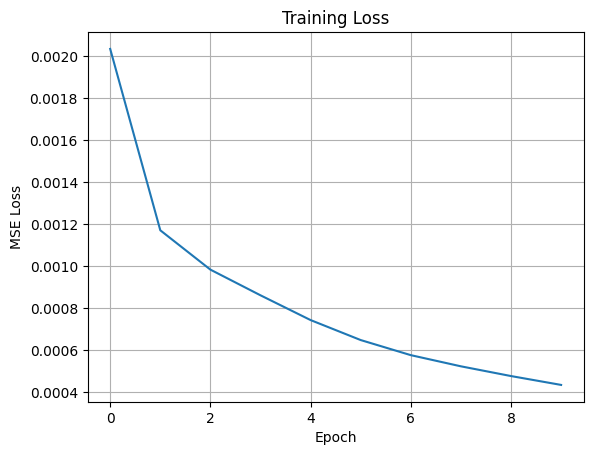

In [ ]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.savefig("training_loss.png")

In [ ]:
torch.save(model.state_dict(), 'convolutional_network.pth')

NameError: name 'torch' is not defined